# Computer Simulation: Output Analysis

**In the lab you will learn how to :**

* how to perform multiple replications of a simulation model implemented in `simpy`.
* how to estimate and use warm-up period of a non-terminating simulation model.
* how to select the number of replications to run of a single scenario.
* how to informally compare multiple competing scenarios

-----

# Imports

Please use the provided `hds_stoch` environment for this work.  

In [1]:
#!pip install simpy~

import simpy
simpy.__version__

'4.0.1'

# Standard imports

In [38]:
import numpy as np
import pandas as pd
import itertools
import math
import matplotlib.pyplot as plt
import warnings
from scipy.stats import t

# Import model classes

In [3]:
from hds_simpy.models.UrgentCareCallCentre import (UrgentCareCallCentre, 
                                                   Scenario,
                                                   single_run,
                                                   multiple_replications)

# Exercise 1: Test a single run of the model

**Task**
* Run the code below to perform a single run of the model.
* Try changing `random_no_set` parameter of `single_run` to see different results
* **Optional**: navigate to `hds_simpy/models/UrgentCareCallCentre` and read the code for `single_run()`

**Questions**
* How you would intutively go about implementing multiple replications given this function?


In [4]:
#create the default scenario
args = Scenario()

#use the single_run() func
#try changing `random_no_set` to see different run results
print('Running simulation ...', end=' => ')
results = single_run(args, random_no_set=42)
print('simulation complete.')
results

Running simulation ... => simulation complete.


,nurse_queue,nurse_util,nurse_wait,operator_queue,operator_wait,ops_util
rep,,,,,,
1,3.121019,0.893938,3.471573,5.6591,2.867722,0.927969


# Exercise 2: Multiple replications of the model

**Task:**
* Read and run the code below.
* Try changing the number of replications (e.g. 10 or 20).

In [5]:
#default scenario
args = Scenario()

#run multiple replications.
#by default it runs 5 replications.
print('Running multiple replications', end=' => ')
results  = multiple_replications(args, n_reps=5)
print('done.\n')

#show reps rounded to 2dp
results.round(2)

Running multiple replications => done.



,nurse_queue,nurse_util,nurse_wait,operator_queue,operator_wait,ops_util
rep,,,,,,
1,3.34,0.94,4.08,9.66,5.15,0.96
2,3.46,0.91,4.16,6.17,3.27,0.96
3,5.10,0.91,6.47,7.35,3.94,0.94
4,2.26,0.88,2.62,5.25,2.79,0.93
5,1.99,0.88,2.36,4.31,2.26,0.93


In [6]:
results.mean()

nurse_queue       3.229965
nurse_util        0.902998
nurse_wait        3.935206
operator_queue    6.548883
operator_wait     3.481246
ops_util          0.943910
dtype: float64

# Exercise 3: Graphical plots of the replications

To understand the spread of your replication results it is sometimes useful to plot a histogram.

**Task**
* Run 50 replications of the model
* Plot a histogram of the `nurse_queue` and `operator_wait` variables.

**Hints**:
* To plot a histogram you can use the following code:

```python
#results is a dataframe returned from the multi reps func
fig, ax = plt.subplots(2, 1, figsize=(12,4))
ax[0].hist(results['nurse_queue']);
ax[1].hist(results['operator_wait']);
```

In [7]:
# your code here ...

Running multiple replications => done.



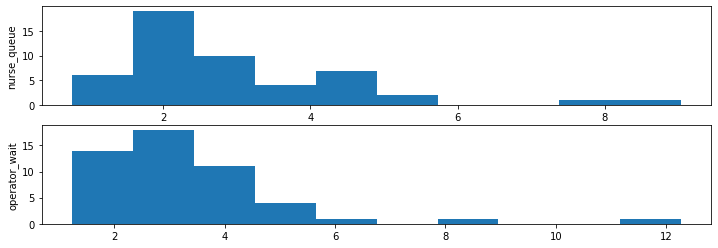

In [9]:
args = Scenario()

#run multiple replications.
#by default it runs 5 replications.
print('Running multiple replications', end=' => ')
results  = multiple_replications(args, n_reps=50)
print('done.\n')

fig, ax = plt.subplots(2, 1, figsize=(12,4))
ax[0].hist(results['nurse_queue']);
ax[0].set_ylabel('nurse_queue')
ax[1].hist(results['operator_wait']);
ax[1].set_ylabel('operator_wait');

# Exercise 4: Coding your own multiple replications function.

Here is where the benefit of using functions to organise your experimentation really pays off!  To perform multiple replications we just need to call `single_run` multiple times in a loop.

**Task**:

* Complete function below called `my_multiple_replications`.  
* The function should accept the following parameters:
   * scenario: `Scenario` - Parameters/arguments to configure the model
   * rc_period: `int` (default=1440) - the results collection period. i.e. the minutes to run the model in simulated time beyond the warmup period.
   * warm_up: the warm up period of the model where no results are collected.  This should be optional.  Give it a default value of (0).
   * n_reps: `int`, optional (default=5) - Number of independent replications to run.
* The purpose of `my_multiple_replications` is to conduct `n_reps` independent replications of the model.
* The function should return a list, array or dataframe of replication results.
* After coding the function conduct 5 replications of the model.

**Hints**
* You need to `single_run` in a `for` loop
* Alternatively you could make use of a list comprehension.



In [10]:
def my_multiple_replications(scenario, rc_period=1440, warm_up=0, n_reps=5):
    #your code here ...
    pass

In [11]:
#example solution
def my_multiple_replications(scenario, rc_period=1440, warm_up=0, n_reps=5):
    '''
    Perform multiple replications of the model.
    
    Params:
    ------
    scenario: Scenario
        Parameters/arguments to configurethe model
    
    rc_period: float, optional (default=DEFAULT_RESULTS_COLLECTION_PERIOD)
        results collection period.  
        the number of minutes to run the model beyond warm up
        to collect results
    
    warm_up: float, optional (default=0)
        initial transient period.  no results are collected in this period

    n_reps: int, optional (default=DEFAULT_N_REPS)
        Number of independent replications to run.
        
    Returns:
    --------
    pandas.DataFrame
    '''
    #implemented as list comprehension, but could also be for loop.
    #note that I a have not set single_run's random_no_set parameter
    #     this means that it produces a different result on each run
    #   
    results = [single_run(scenario, rc_period, warm_up) 
               for rep in range(n_reps)]
    
    #format and return results in a dataframe
    df_results = pd.concat(results)
    df_results.index = np.arange(1, len(df_results)+1)
    df_results.index.name = 'rep'
    return df_results
        

In [12]:
#default scenario
args = Scenario()

print('Running multiple replications', end=' => ')
results = my_multiple_replications(args, n_reps=5)
print('done.\n')
results

Running multiple replications => done.



,nurse_queue,nurse_util,nurse_wait,operator_queue,operator_wait,ops_util
rep,,,,,,
1,1.167224,0.853496,1.303224,5.543162,2.904578,0.918664
2,3.362334,0.926154,4.046199,3.975703,2.060296,0.920280
3,2.713243,0.905302,3.250185,5.123605,2.623410,0.944980
4,5.085624,0.892340,6.245107,5.166806,2.709423,0.935830
5,1.784934,0.875009,2.017789,4.048568,2.077554,0.937660


# Exercise 5: Controlling sampling across multiple replications

The `single_run` function allows you to set a `random_no_set`.  In **exercise 1** you saw that the parameter controlled random sampling in a single run of the model. I.e. each random number set results in a unique set of sample combinations from each of the probability distributions in the model (e.g. arrivals and call duration).

Your `my_multiple_replications` function has a lot of benefits.  However, it produces a different batch of replication values each time your run it because the code does not not set `random_no_set` on each replication.  

To make this work you need to ensure that each replication uses a unique random no set.  An easy way to do this is to use the **replication number**.

**Task**:
* Modify your `my_multiple_replications` function
* When calling the `single_run` function set the `random_no_set` to the current replication iteration number.
* Run 5 replications of your model.
* **Optional**: navigate to `hds_simpy/models/UrgentCareCallCentre` and read the code for `single_run()` and the class`Scenario`
   * In particular, look at the methods `set_random_no_set()` and `init_sampling()` in the `Scenario` class
   * (be careful not to change any code because might break the model!)

**Questions:**
* Try running your code multiple times. Does your code work?  Are your results repeatable?

**Hints**:
* Assuming you have implemented multiple replications in a `for` loop like the below then the you would use `rep` as your `random_no_set` in each call to `single_run()`

```python
for rep in range(n_reps):
    pass
```






In [12]:
#your code here ... (recommend copy pasting your answer to ex 4)

In [13]:
#example solution
def my_multiple_replications(scenario, rc_period=1440, warm_up=0, n_reps=5):
    '''
    Perform multiple replications of the model.
    
    Params:
    ------
    scenario: Scenario
        Parameters/arguments to configurethe model
    
    rc_period: float, optional (default=DEFAULT_RESULTS_COLLECTION_PERIOD)
        results collection period.  
        the number of minutes to run the model beyond warm up
        to collect results
    
    warm_up: float, optional (default=0)
        initial transient period.  no results are collected in this period

    n_reps: int, optional (default=DEFAULT_N_REPS)
        Number of independent replications to run.
        
    Returns:
    --------
    pandas.DataFrame
    '''
    #I have now set single_run's random_no_set parameter
    #this means that each replication has controlled reproducible sampling.
    results = [single_run(scenario, rc_period, warm_up, random_no_set=rep) 
               for rep in range(n_reps)]
    
    #format and return results in a dataframe
    df_results = pd.concat(results)
    df_results.index = np.arange(1, len(df_results)+1)
    df_results.index.name = 'rep'
    return df_results
        

In [16]:
#default scenario
args = Scenario()

print('Running multiple replications', end=' => ')
results = my_multiple_replications(args, n_reps=5)
print('done.\n')
results

Running multiple replications => done.



,nurse_queue,nurse_util,nurse_wait,operator_queue,operator_wait,ops_util
rep,,,,,,
1,3.344262,0.937849,4.079014,9.663681,5.147623,0.961942
2,3.455683,0.907009,4.158595,6.170641,3.269568,0.957109
3,5.095833,0.906577,6.465196,7.349916,3.943983,0.940515
4,2.259419,0.879775,2.615945,5.253068,2.786155,0.929235
5,1.994629,0.883779,2.357280,4.307110,2.258900,0.930750


In [17]:
#mean results
results.mean()

nurse_queue       3.229965
nurse_util        0.902998
nurse_wait        3.935206
operator_queue    6.548883
operator_wait     3.481246
ops_util          0.943910
dtype: float64

# Exercise 6: Estimating a warm-up period
## Exercise 6.a Generating the warm-up replication data

Your UrgentCareCallCentre model is a **non-terminating** system.  To estimate a warm-up period of the model you will use the **time series inspection approach**.  You will run 5 replications of the model and plot the cumulative mean performance measures at regular audit intervals (for example every 120 minutes).  With the time series inspection method you the choose a warm-up that allows the model to approximately settle to a steady state.

There is a pre-written function `warmup_analysis` to help you with this task.  The function takes the following parameters:

* `scenario`: a `Scenario` object.  Use the default settings
* `rc_period`: float.  The result collection period
* `interval`: float.  The interval between audits of the model. (default=120)
* `n_reps`: int. The number of replications to run.

You can import it via 

```python
from hds_simpy.models.UrgentCareCallCentre import warmup_analysis
```

The function returns a python `dict`.  The dict has the following keys: 'operator_wait', 'nurse_wait', 'operator_util', 'nurse_util'. Each item in the dict is a `pd.DataFrame`.  For example, to access the 'nurse_wait' results use the following code:

```python
#assume results dict is called 'results'
results['nurse_wait'].head()
```

> The warmup analysis code works just the same as `multiple_replications`.  The main difference is that 
a class called `WarmupAuditor` is used to periodically record the waiting times and utilisations.  Navigate to `hds_simpy/models/UrgentCareCallCentre` and checkout the function `warmup_single_run()` and the class `WarmupAuditor`.  The latter is a 'wrapper class' to UrgentCareCallCentre.

**Task:**
* Using the function provided and the code below run the model for 
    * 40 days (40 * 1440 minutes)
    * 5 replications.
    * with an audit interval of 120 minutes.



In [18]:
from hds_simpy.models.UrgentCareCallCentre import warmup_analysis

In [19]:
%%time
#script
#note this will take 5-30 seconds to run depending on your machine

#run for 40 days
RUN_LENGTH = 1440 * 40

#run at least 5 replications, but more might be needed for noisy data
N_REPS = 10

#default scenario
args = Scenario()

#run warm up analysis for scenario
print('Running warm-up analysis with replications. Please wait...', end=' => ')
results = warmup_analysis(args, rc_period=RUN_LENGTH, n_reps=N_REPS)
print('done.')

Running warm-up analysis with replications. Please wait... => done.
CPU times: user 68.2 ms, sys: 3.25 ms, total: 71.5 ms
Wall time: 22 s


In [20]:
results['operator_wait'].head()

,rep_1,rep_2,rep_3,rep_4,rep_5,rep_6,rep_7,rep_8,rep_9,rep_10
audit,,,,,,,,,,
1,1.205320,1.508978,10.348044,1.674365,1.571362,0.627821,2.598540,0.601558,1.931042,0.838892
2,4.829887,1.590010,10.462567,1.032798,3.142770,1.129403,2.167782,2.283145,1.717842,1.296022
3,4.243036,3.811480,7.314008,0.866694,4.479818,1.182105,2.359020,3.823246,1.741467,3.949125
4,3.835060,3.921560,5.796817,0.895268,3.970268,1.909022,1.942557,4.177840,1.726391,3.322851
5,3.857931,3.536040,5.417880,1.205532,3.329453,1.791779,2.341889,3.780762,1.881169,3.425909


## Exercise 6.b. Plotting the time series

Now that you have your replication data you can plot the time series and inspect it.  To help you the function `time_series_inspection` has been provided.  Note that this function is specific to this model, but you could easily adapt for another problem with different performance measures.

**Task**:
* Run the code below and make a decision about a warm-up period.

**Hints**
* `time_series_inspection` takes a parameter called `warm_up`.  This will plot a vertical red line.  Use it to help you decided where to make the cut-off. 
* Try values in the range 150-250
* If you think the data is too noisy go back and run 10 replications instead of 5 and then try again.

In [21]:
def time_series_inspection(results, warm_up=None):
    '''
    Time series inspection method
    
    Parameters:
    ----------
    results: dict
        The dict of results taken from warmup_analysis
    '''
    
    #create the 4 chart areas to plot
    fig, ax = plt.subplots(2, 2, figsize=(12,9))
    
    #take the mean of the columns for each metric and plot
    ax[0][0].plot(results['operator_wait'].mean(axis=1))
    ax[0][1].plot(results['nurse_wait'].mean(axis=1))
    ax[1][0].plot(results['operator_util'].mean(axis=1))
    ax[1][1].plot(results['nurse_util'].mean(axis=1))

    #set the label of each chart
    ax[0][0].set_ylabel('operator_wait')
    ax[0][1].set_ylabel('nurse_wait')
    ax[1][0].set_ylabel('operator_util')
    ax[1][1].set_ylabel('nurse_util')

    if warm_up is not None:
        #add warmup cut-off vertical line if one is specified
        ax[0][0].axvline(x=warm_up, color='red', ls='--')
        ax[0][1].axvline(x=warm_up, color='red', ls='--')
        ax[1][0].axvline(x=warm_up, color='red', ls='--')
        ax[1][1].axvline(x=warm_up, color='red', ls='--')
    
    return fig, ax

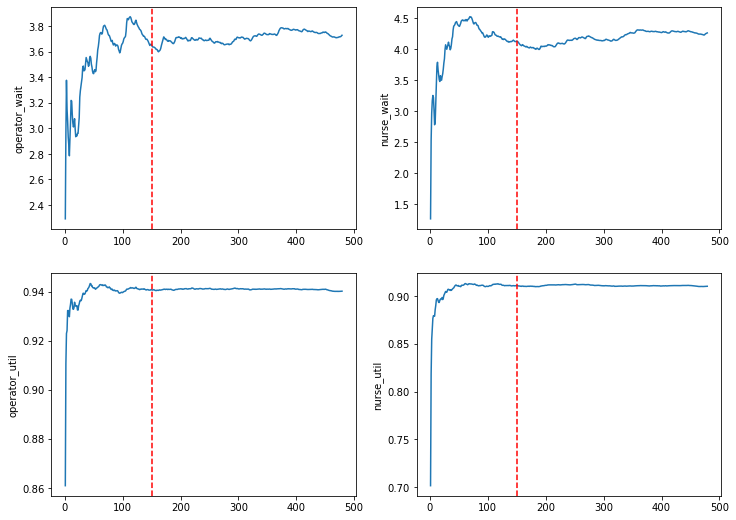

In [22]:
#this assumes you assigned the output of warmup_analysis to a varible 'results'
fig, ax = time_series_inspection(results, warm_up=150)

## Exercise 6.c rerunning the model with warm up time 
Now that you have selected a warmup period you can rerun the model and delete the initial transient period.  To do this it is recommended you make use of the supplied function `multiple_replications`

**Task:**
* Use the code below to rerun the model.
* Run 100 replications of your model.

**Hints**
* Notice that the you are now passing a warm-up period to `multiple_replications`.
* You will use these replications in the next exercise so remember the name of the results variable.
* Depending on your machine and the warm-up you have chosen it will take 60-90 seconds to run 100 replications.


In [78]:
%%time 

############## MODIFICATION  ################################
#set models warmup period
AUDIT_INTERVAL = 120
#set this to the value you selected e.g. between 150 and 250
WARM_UP_INTERVALS = 170 
#this converts you warmup interval into minutes.
WARM_UP = WARM_UP_INTERVALS * AUDIT_INTERVAL
##############################################################

#results collection over a single day
RC_PERIOD = 1440

#number of replications
N_REPS = 100

#default scenario
args = Scenario()

#run multiple replications.
print('Running multiple replications', end=' => ')
replications  = multiple_replications(args, rc_period=RC_PERIOD, warm_up=WARM_UP,
                                      n_reps=N_REPS)
print('done.\n')

#show results summary rounded to 2dp
replications.describe().round(2)

Running multiple replications => done.

CPU times: user 353 ms, sys: 21.7 ms, total: 375 ms
Wall time: 1min 29s


,nurse_queue,nurse_util,nurse_wait,operator_queue,operator_wait,ops_util
count,100.00,100.00,100.00,100.00,100.00,100.00
mean,3.39,0.91,4.22,6.98,3.74,0.94
std,0.57,0.01,0.77,1.17,0.66,0.00
min,2.38,0.89,2.86,4.54,2.39,0.93
25%,2.99,0.90,3.68,6.31,3.37,0.94
50%,3.37,0.91,4.20,6.84,3.66,0.94
75%,3.68,0.91,4.60,7.49,4.01,0.94
max,5.47,0.92,7.09,13.03,7.16,0.95


# Selecting the number of replications to run.

You will now use the **confidence interval method** to select the number replications to run in order to get a good estimate the models mean performance.  The narrower the confidence interval the more precise our estimate of the mean. In general, the more replications you run the narrower the confidence interval. The method requires you to set a predefined width of the confidence interval.  In this course, we will make the somewhat arbitrary decision to opt for an interval that is 10% or 5% either side of the mean.

A confidence interval is calculated as:

$$ CI = \overline{X} \pm t_{n-1, \alpha/2} \dfrac{S}{\sqrt{n}}$$


where: 

* $\overline{X}$ = mean of the output data from the replications
* $S$ = standard deviation of the output data from the replications
* $n$ = the number of replications
* $t_{n-1, \alpha/2}$ = value from the *t*-distribution with $n-1$ degrees of freedomand a significance level of $\alpha/2$

## Implementation in python

The function `confidence_interval_method` is provided for you.  

In [79]:
def confidence_interval_method(replications, alpha=0.05, desired_precision=0.05, 
                               min_rep=5, decimal_place=2):
    '''
    The confidence interval method for selecting the number of replications
    to run in a simulation.
    
    Finds the smallest number of replications where the width of the confidence
    interval is less than the desired_precision.  
    
    Returns both the number of replications and the full results dataframe.
    
    Parameters:
    ----------
    replications: arraylike
        Array (e.g. np.ndarray or list) of replications of a performance metric
        
    alpha: float, optional (default=0.05)
        procedure constructs a 100(1-alpha) confidence interval for the 
        cumulative mean.
        
    desired_precision: float, optional (default=0.05)
        Desired mean deviation from confidence interval.
        
    min_rep: int, optional (default=5)
        set to a integer > 0 and ignore all of the replications prior to it 
        when selecting the number of replications to run to achieve the desired
        precision.  Useful when the number of replications returned does not
        provide a stable precision below target.
        
    decimal_places: int, optional (default=2)
        sets the number of decimal places of the returned dataframe containing
        the results
    
    Returns:
    --------
        tuple: int, pd.DataFrame
    
    '''
    n = len(replications)
    cumulative_mean = [replications[0]]
    running_var = [0.0]
    for i in range(1, n):
        cumulative_mean.append(cumulative_mean[i-1] + \
                       (replications[i] - cumulative_mean[i-1] ) / (i+1))
        
        #running biased variance
        running_var.append(running_var[i-1] + (replications[i] 
                                               - cumulative_mean[i-1]) \
                            * (replications[i] - cumulative_mean[i]))
        
    #unbiased std dev = running_var / (n - 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        running_std = np.sqrt(running_var / np.arange(n))
    
    #half width of interval
    dof = len(replications) - 1
    t_value = t.ppf(1 - (alpha / 2),  dof)    
    with np.errstate(divide='ignore', invalid='ignore'):
        std_error = running_std / np.sqrt(np.arange(1, n+1))
        
    half_width = t_value * std_error
        
    #upper and lower confidence interval
    upper = cumulative_mean + half_width
    lower = cumulative_mean - half_width
    
    #Mean deviation
    with np.errstate(divide='ignore', invalid='ignore'):
        deviation = (half_width / cumulative_mean) * 100
    
    #commbine results into a single dataframe
    results = pd.DataFrame([replications, cumulative_mean, 
                            running_std, lower, upper, deviation]).T
    results.columns = ['Mean', 'Cumulative Mean', 'Standard Deviation', 
                       'Lower Interval', 'Upper Interval', '% deviation']
    results.index = np.arange(1, n+1)
    results.index.name = 'replications'
    
    #get the smallest no. of reps where deviation is less than precision target
    try:
        n_reps = results.iloc[min_rep:].loc[results['% deviation'] 
                             <= desired_precision*100].iloc[0].name
    except:
        #no replications with desired precision
        message = 'WARNING: the replications do not reach desired precision'
        warnings.warn(message)
        n_reps = -1 

    
    return n_reps, results.round(2)
        

## Step 1: pass the replications to the method

The function `confidence_interval_method` returns a tuple `(int, pandas.DataFrame)`.  The first element is the minimum number of replications required to achieve the precision (desired width of the interval).  The second, element is all of the data including the confidence interval.

In [80]:
#run the method on the operator_wait replications
n_reps, conf_ints = confidence_interval_method(replications['operator_wait'].to_numpy(),
                                               desired_precision=0.05)

#print out the min number of replications to achieve precision
print(f'\nminimum number of reps for 5% precision: {n_reps}\n')

#peek at table of results
conf_ints.head()


minimum number of reps for 5% precision: 21



,Mean,Cumulative Mean,Standard Deviation,Lower Interval,Upper Interval,% deviation
replications,,,,,,
1,3.98,3.98,NaN,NaN,NaN,NaN
2,3.47,3.72,0.36,3.21,4.23,13.68
3,3.85,3.76,0.27,3.46,4.07,8.10
4,3.44,3.68,0.27,3.41,3.95,7.34
5,3.07,3.56,0.36,3.24,3.88,9.04


## Step 2: Plot the results

It is useful to look at the results visually to check if the confidence intervals converge or if the expand again later on.

The function `plot_confidence_interval_method` has been provided to help.

Run the code below to produce the plot.  Do you think it looks stable?


In [81]:
def plot_confidence_interval_method(n_reps, conf_ints, metric_name, 
                                    figsize=(12,4)):
    '''
    Plot the confidence intervals and cumulative mean
    
    Parameters:
    ----------
    n_reps: int
        minimum number of reps selected
        
    conf_ints: pandas.DataFrame
       results of the `confidence_interval_method` function
       
    metric_name: str
        Name of the performance measure
        
    figsize: tuple, optional (default=(12,4))
        The size of the plot
        
    Returns:
    -------
        matplotlib.pyplot.axis
    '''
    #plot cumulative mean + lower/upper intervals
    ax = conf_ints[['Cumulative Mean', 'Lower Interval', 
                         'Upper Interval']].plot(figsize=figsize)
    #add the 
    ax.axvline(x=n_reps, ls='--', color='red')
    
    ax.set_ylabel(f'cumulative mean: {metric_name}')
    
    return ax

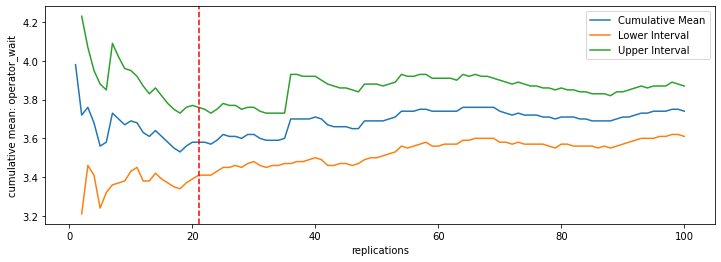

In [82]:
#plot the confidence intervals
ax = plot_confidence_interval_method(n_reps, conf_ints, 
                                     metric_name='operator_wait')

# Step 3: Look ahead

Another good idea is to check the % deviation 10-20 replications ahead to check quantitatively that the 5% precision is maintained.

In [87]:
#quick check if the % deviation remains below 5% for the next 10 reps?
lookahead = 15
conf_ints.iloc[n_reps-1:n_reps+lookahead]

,Mean,Cumulative Mean,Standard Deviation,Lower Interval,Upper Interval,% deviation
replications,,,,,,
21,3.67,3.58,0.41,3.41,3.76,4.93
22,3.48,3.58,0.40,3.41,3.75,4.72
23,3.37,3.57,0.39,3.41,3.73,4.55
24,4.01,3.59,0.39,3.43,3.75,4.45
25,4.29,3.62,0.41,3.45,3.78,4.50
26,3.40,3.61,0.40,3.45,3.77,4.36
27,3.74,3.61,0.40,3.46,3.77,4.20
28,3.26,3.60,0.40,3.45,3.75,4.12
29,4.09,3.62,0.40,3.47,3.76,4.06


# Step 4: Rerun the CI analysis

You should find that the CI deviation exceeds 5% again after 36 replications.  Let's rerun `confidence_interval_method` and set the `min_rep` parameters to 36.  This means we will begin our checking at least at replication 36.


minimum number of reps for 5% precision: 51



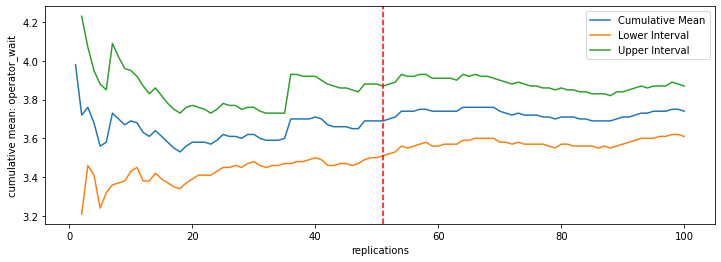

In [89]:
#run the method on the operator_wait replications
n_reps, conf_ints = confidence_interval_method(replications['operator_wait'].to_numpy(),
                                               desired_precision=0.05, min_rep=36)


#print out the min number of replications to achieve precision
print(f'\nminimum number of reps for 5% precision: {n_reps}\n')

#plot the confidence intervals
ax = plot_confidence_interval_method(n_reps, conf_ints, 
                                     metric_name='operator_wait')



# Handling Utilisation.

The method is unstable for values close to zero.  As the utilisation measures are between 0 and 1 it is recommended that you multiple the values by 100. For example, to handle operator utilisation you would use the following code:

Analysis of replications for operator utilisation...

minimum number of reps for 5% precision: 51



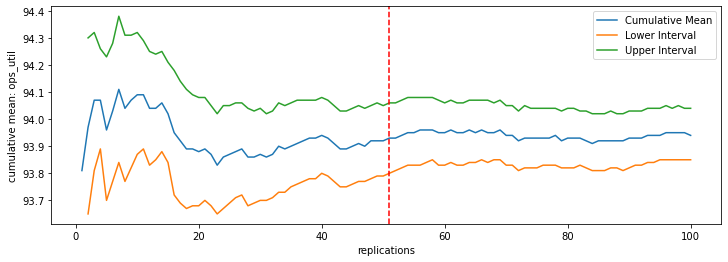

In [109]:
#run the method on the opts util replications
#We already know that we have to run > 50 reps so set min_rep parameter = 50.
n_reps, conf_ints = confidence_interval_method(replications['ops_util'].to_numpy() * 100,
                                               desired_precision=0.05, min_rep=50)

print('Analysis of replications for operator utilisation...')

#print out the min number of replications to achieve precision
print(f'\nminimum number of reps for 5% precision: {n_reps}\n')

#plot the confidence intervals
ax = plot_confidence_interval_method(n_reps, conf_ints, 
                                     metric_name='ops_util')

# Exercise 7: Number of replications for nurse variables

When selecting the number of replications you should repeat the analysis for all performance measures and select the highest value as your number of replications.

**Task**:
* Use the confidence interval method with the `nurse_wait` and `nurse_util` performance measures.

**Questions:**
* What number of replications would you choose for your model?

**Hints:**
* You don't need to rerun any replications.  You can reuse the replications you have already run.
* You already know that you need to run at least 50 replications so set the `min_rep` parameter of `confidence_interval_method` to 50.

In [ ]:
# your code here...

Analysis of replications for nurse waiting time...

minimum number of reps for 5% precision: 51



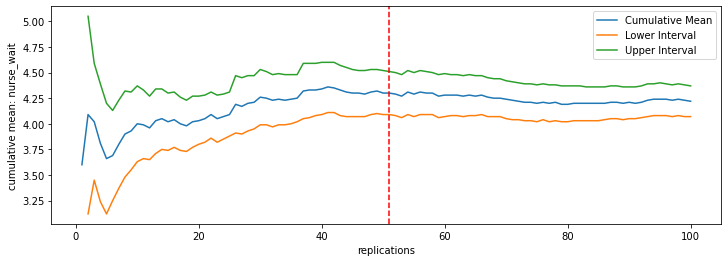

In [103]:
#example answer

#run the method on the nurse_wait replications
n_reps, conf_ints = confidence_interval_method(replications['nurse_wait'].to_numpy(),
                                               desired_precision=0.05, min_rep=50)

print('Analysis of replications for nurse waiting time...')

#print out the min number of replications to achieve precision
print(f'\nminimum number of reps for 5% precision: {n_reps}\n')

#plot the confidence intervals
ax = plot_confidence_interval_method(n_reps, conf_ints, 
                                     metric_name='nurse_wait')

Analysis of replications for nurse waiting time...

minimum number of reps for 5% precision: 51



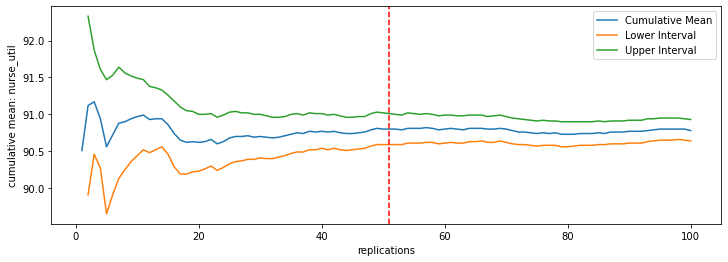

In [102]:
#run the method on the nurse_wait replications
n_reps, conf_ints = confidence_interval_method(replications['nurse_util'].to_numpy() * 100,
                                               desired_precision=0.05, min_rep=50)

print('Analysis of replications for nurse waiting time...')

#print out the min number of replications to achieve precision
print(f'\nminimum number of reps for 5% precision: {n_reps}\n')

#plot the confidence intervals
ax = plot_confidence_interval_method(n_reps, conf_ints, 
                                     metric_name='nurse_util')

# Exercise 8: Scenario Analysis
## Exercise 8a: Organising your code

**Task**:

* Complete the `get_scenarios` function below.  You should create the following scenarios:
    * 1 additional operator
    * 1 additional nurse
    * A combination of the first two scenarios

In [115]:
#task: complete this function

def get_scenarios():
    '''
    Creates a dictionary object containing
    objects of type `Scenario` to run.
    
    Returns:
    --------
    dict
        Contains the scenarios for the model
    '''
    scenarios = {}
    scenarios['base'] = Scenario()
    
    ########## MODIFICATION HERE ##########################
    # your code here...
    # scenarios['operator+1'] = ...
    # scenarios['nurse+1'] = ...
    # scenarios['operator+nurse'] = ...
    
    
    #######################################################
    
    return scenarios

In [120]:
#example answer
def get_scenarios():
    '''
    Creates a dictionary object containing
    objects of type `Scenario` to run.
    
    Returns:
    --------
    dict
        Contains the scenarios for the model
    '''
    scenarios = {}
    scenarios['base'] = Scenario()
    
    ########## MODIFICATION HERE ##########################
    # your code here...
    scenarios['operator+1'] = Scenario()
    scenarios['operator+1'].n_operators += 1
    
    scenarios['nurse+1'] = Scenario()
    scenarios['nurse+1'].n_nurses += 1
    
    scenarios['operator+nurse'] = Scenario()
    scenarios['operator+nurse'].n_operators += 1
    scenarios['operator+nurse'].n_nurses += 1
    
    #######################################################
    
    return scenarios

In [121]:
def run_scenario_analysis(scenarios, rc_period, warm_up, n_reps):
    '''
    Run each of the scenarios for a specified results
    collection period, warmup and replications.
    
    (note if you have lots of scenarios this may take several minutes)
    '''
    print('Scenario Analysis')
    print(f'No. Scenario: {len(scenarios)}')
    print(f'Replicatins: {n_reps}')
    
    
    scenario_results = {}
    for sc_name, scenario in scenarios.items():
        
        print(f'Running {sc_name}', end=' => ')
        replications  = multiple_replications(scenario, rc_period=RC_PERIOD, 
                                              warm_up=warm_up,
                                              n_reps=n_reps)
        print('done.\n')
        
        #save the results
        scenario_results[sc_name] = replications
    
    print('Scenario analysis complete.')
    return scenario_results

In [122]:
#script to run model
#note: for 4 scenarios and 50 reps this will take a few minutes.

#set models warmup period
AUDIT_INTERVAL = 120
#set this to the value you selected e.g. between 150 and 250
WARM_UP_INTERVALS = 170 
#this converts you warmup interval into minutes.
WARM_UP = WARM_UP_INTERVALS * AUDIT_INTERVAL

#results collection over a single day
RC_PERIOD = 1440

#number of replications
N_REPS = 51

#get the scenarios
scenarios = get_scenarios()

#run the scenario analysis
scenario_results = run_scenario_analysis(scenarios, RC_PERIOD, WARM_UP,
                                         N_REPS)

Scenario Analysis
No. Scenario: 4
Replicatins: 51
Running base => done.

Running operator+1 => done.

Running nurse+1 => done.

Running operator+nurse => done.

Scenario analysis complete.


In [125]:
#take a peek at the results for the 1st scenario
scenario_results['operator+1'].head()

,nurse_queue,nurse_util,nurse_wait,operator_queue,operator_wait,ops_util
rep,,,,,,
1,3.526576,0.905196,4.386900,2.650300,1.275251,0.871221
2,4.072445,0.917331,5.093389,2.334577,1.110028,0.874182
3,3.591518,0.912603,4.502610,2.503826,1.199095,0.875302
4,3.156041,0.902641,3.916148,2.343832,1.111692,0.873785
5,2.747441,0.890792,3.385750,2.169525,1.024595,0.868797


## Exercise 8.b: Presenting the results

There are always a lot of options to present your results.  A bare minimum is to present a simple table of results.

The function `scenario_summary_frame` illustrates one way to combine mean results into a single dataframe.
The script below it then renames the rows and columns to something more suitable to a report.

In [135]:
def scenario_summary_frame(scenario_results):
    '''
    Mean results for each performance measure by scenario
    
    Parameters:
    ----------
    scenario_results: dict
        dictionary of replications.  
        Key identifies the performance measure
        
    Returns:
    -------
    pd.DataFrame
    '''
    columns = []
    summary = pd.DataFrame()
    for sc_name, replications in scenario_results.items():
        summary = pd.concat([summary, replications.mean()], axis=1)
        columns.append(sc_name)

    summary.columns = columns
    return summary

In [139]:
#as well as rounding you may want to rename the cols/rows to 
#more readable alternatives.
summary_frame = scenario_summary_frame(scenario_results)
summary_frame.round(2)

,base,operator+1,nurse+1,operator+nurse
nurse_queue,3.44,3.99,1.14,1.40
nurse_util,0.91,0.91,0.83,0.83
nurse_wait,4.30,5.03,1.22,1.53
operator_queue,6.89,2.43,6.89,2.43
operator_wait,3.69,1.16,3.69,1.16
ops_util,0.94,0.87,0.94,0.87


# End